In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from sqlite3 import Error

resultDir= "configure me"
repeatCount="me too"

#scenarioExt="maxMacQueueSize34-P5" for reliability (DDR) results 
#scenarioExt="maxMacQueueSize34-P0-60s" for throughput results 
#scenarioExt="maxMacQueueSize34-P5-60s" for delay results 


def getScalarValueFromDB(dbConnexion, query):
    cursor=dbConnexion.cursor()
    cursor.execute(query)
    return cursor.fetchone()[0]

def getDBPath(scenario,offeredLoadRate,disruptiveTrafficLevel,repeatID):
    tmp= resultDir+"/"+scenario+"-"+scenarioExt+"/"+scenario+"-OfferedLoadRate="+str(offeredLoadRate)
    tmp+=",disruptiveTrafficLevel="+str(disruptiveTrafficLevel);
    tmp+=",nbrTrs=30,bitrate=6,packetLength=200,area=10,repeatID="+str(repeatID)+"-#0.sca"
    return tmp
    
def getThroughputMeanAndStd(scenario,OfferedLoadRate,disruptiveTrafficLevel):
    def getThroughput(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID):
        query="SELECT avg(v.scalarValue)*0.000001 FROM scalar v where v.scalarName='throughput:mean' and v.scalarValue NOT NULL"
        # times 0.000001 in the query is to convert from bps to mbps  
        dbPath=getDBPath(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID)
        dbConn = sqlite3.connect(dbPath)
        return getScalarValueFromDB(dbConn, query)*10 # times 10 is to get the total throughput of the 10 node peers
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getThroughput(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID))
    return [np.mean(values),np.std(values)]     


def getDelayMeanAndStd(scenario,OfferedLoadRate,disruptiveTrafficLevel):
    def getDelay(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID):
        query="SELECT avg(v.scalarValue)*1000 FROM scalar v where v.scalarName='delay:mean' and  v.scalarValue NOT NULL"
        # times 1000 in the query is to convert from secand to millisecond
        dbPath=getDBPath(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID)
        #print(dbPath)
        dbConn = sqlite3.connect(dbPath)
        return getScalarValueFromDB(dbConn, query)
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getDelay(scenario,OfferedLoadRate,disruptiveTrafficLevel,repeatID))
    return [np.mean(values),np.std(values)]  


def getReliabilityMeanAndStd(scenario,offeredLoadRate,disruptiveTrafficLevel):
    def getReliability(scenario,offeredLoadRate,disruptiveTrafficLevel,repeatID):
        dbPath=getDBPath(scenario,offeredLoadRate,disruptiveTrafficLevel,repeatID)
        dbConn = sqlite3.connect(dbPath)

        tmpList=[]
        for moduleIndex in range(10,20):
            sentPkQuery = "SELECT scalarValue FROM scalar WHERE scalarName='sentPk:count' AND (moduleName like '%node["+str(moduleIndex)+"].applLayer[0]' OR moduleName like '%node["+str(moduleIndex)+"].applLayer[1]' OR moduleName like '%node["+str(moduleIndex)+"].applLayer[2]')"
            rcvdPkQuery = "SELECT scalarValue FROM scalar WHERE scalarName='rcvdPk:count' AND (moduleName like '%node["+str(10+moduleIndex)+"].applLayer[0]' OR moduleName like '%node["+str(10+moduleIndex)+"].applLayer[1]' OR moduleName like '%node["+str(10+moduleIndex)+"].applLayer[2]')"
            sentPk = getScalarValueFromDB(dbConn, sentPkQuery)
            rcvdPk = getScalarValueFromDB(dbConn, rcvdPkQuery)
            
            if rcvdPk is not None:
                assert sentPk > 0 
                tmpList.append(rcvdPk/sentPk)

        return np.mean(tmpList)
    
    values=[]
    for repeatID in range(repeatCount):
        values.append(getReliability(scenario,offeredLoadRate,disruptiveTrafficLevel,repeatID))
    return [np.mean(values)*100,np.std(values)*100]  # times *100 to convert to %

    
def plotResult(scenario,baseline):
    labels = ["DURATS","Baseline"]
    
    xPlotCord = 0 
    yPlotCord = 0 
    # Initialise the subplot function using number of rows and columns
    fig,ax = plt.subplots(3,2,figsize=(6,7))
    
    for offeredLoadRate in [20,70]:
                    
        for resultTypeCode in range(0,3):
            
            ylabelTitle=""
            scenarioData=[]
            scenarioYerr=[]
            baselineData=[]
            baselineYerr=[] 
            disruptiveTrafficLevels =[]
            xPlotCord=resultTypeCode
            
            if resultTypeCode == 0 :
                ylabelTitle="Delay (ms)"
                for disruptiveTrafficLevel in range(20,101,20):
                    disruptiveTrafficLevels.append(disruptiveTrafficLevel)
                    tmp = getDelayMeanAndStd(scenario,offeredLoadRate,disruptiveTrafficLevel)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
                    tmp = getDelayMeanAndStd(baseline,offeredLoadRate,disruptiveTrafficLevel)
                    baselineData.append(tmp[0])
                    baselineYerr.append(tmp[1])
            elif resultTypeCode == 1 :
                ylabelTitle="Throughput (Mbps)"
                for disruptiveTrafficLevel in range(20,101,20):
                    disruptiveTrafficLevels.append(disruptiveTrafficLevel)
                    tmp = getThroughputMeanAndStd(scenario,offeredLoadRate,disruptiveTrafficLevel)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
                    tmp = getThroughputMeanAndStd(baseline,offeredLoadRate,disruptiveTrafficLevel)
                    baselineData.append(tmp[0])
                    baselineYerr.append(tmp[1])
            elif resultTypeCode == 2 :
                ylabelTitle="Packet delivery rate (%)"
                for disruptiveTrafficLevel in range(20,101,20):
                    disruptiveTrafficLevels.append(disruptiveTrafficLevel)
                    tmp = getReliabilityMeanAndStd(scenario,offeredLoadRate,disruptiveTrafficLevel)
                    scenarioData.append(tmp[0])
                    scenarioYerr.append(tmp[1])
                    tmp = getReliabilityMeanAndStd(baseline,offeredLoadRate,disruptiveTrafficLevel)
                    baselineData.append(tmp[0])
                    baselineYerr.append(tmp[1])
                    
            ax[xPlotCord, yPlotCord].errorbar(disruptiveTrafficLevels,scenarioData,yerr=scenarioYerr,label=labels[0])
            ax[xPlotCord, yPlotCord].errorbar(disruptiveTrafficLevels,baselineData,yerr=baselineYerr,label=labels[1])
            ax[xPlotCord, yPlotCord].set_title("["+str(offeredLoadRate)+"%"" decision traffic load]")
            ax[xPlotCord, yPlotCord].set_ylabel(ylabelTitle)
            handles, labels = ax[xPlotCord, yPlotCord].get_legend_handles_labels()
        
        yPlotCord += 1

    fig.tight_layout(pad=1.0)
    
    lgd=fig.legend(labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2)
    #fig.text(0.55, 0.005, 'Rate of disruptive traffic introduced by dummy traffic generators', ha='center')
    fig.savefig(resultDir+"/"+scenario+scenarioExt+".pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show() 


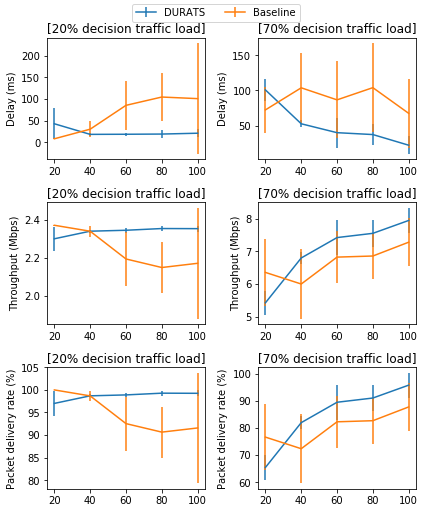

In [117]:
scenario="throughputWeighted"
baseline="naiveThroughputBasedDecision"


plotResult(scenario,baseline)

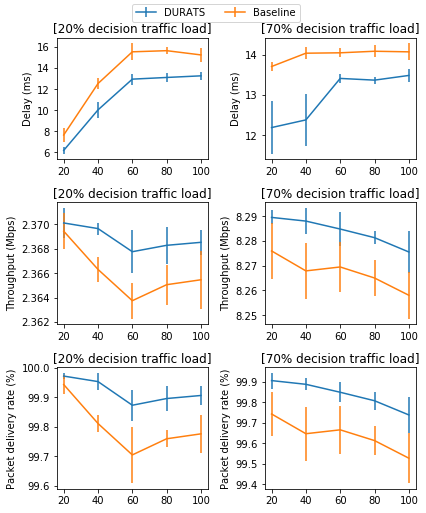

In [108]:
scenario="delayWeighted"
baseline="naiveDelayBasedDecision"

plotResult(scenario,baseline)

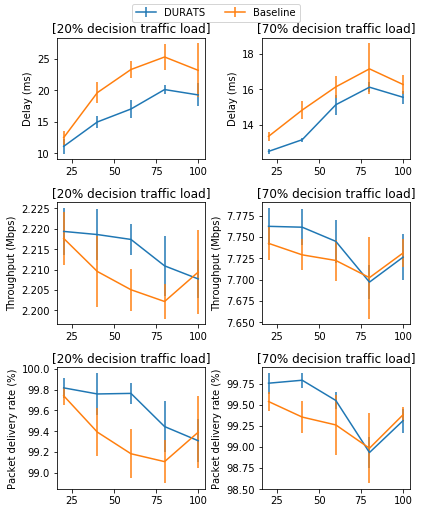

In [126]:
scenario="reliabilityWeighted"
baseline="naiveReliabilityBasedDecision"

plotResult(scenario,baseline)